In [1]:
import os
os.chdir('../')

In [ ]:

# Copyright (C) 18/5/21 RW Bunney

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

import sys
import logging
import time
import simpy

import pandas as pd

sys.path.insert(0, os.path.abspath('../../thesis_experiments'))
sys.path.insert(0, os.path.abspath('../../topsim_pipelines'))
sys.path.insert(0, os.path.abspath('../../shadow'))

from topsim.core.simulation import Simulation
from topsim.core.delay import DelayModel
from user.telescope import Telescope
from user.dynamic_plan import DynamicAlgorithmFromPlan

logging.basicConfig(level="INFO")
logger = logging.getLogger()

algorithms = ['heft', 'fcfs']
global_sim = pd.DataFrame()
global_tasks = pd.DataFrame()

# RUNNING SIMULATION AND GENERATING DATA

for algorithm in algorithms:
    for config in sorted(os.listdir(
            '2021_isc-hpc/config/single_size/40cluster')):
        if '.json' in config:
            CONFIG = f'2021_isc-hpc/config/single_size/40cluster/{config}'
            env = simpy.Environment()
            instrument = Telescope
            timestamp = f'{time.time()}'.split('.')[0]
            simulation = Simulation(
                env=env,
                config=CONFIG,
                instrument=instrument,
                planning=algorithm,
                scheduling=DynamicAlgorithmFromPlan,
                delay=None,
                timestamp={timestamp}
            )
            sim, tasks = simulation.start()
            global_sim = global_sim.append(sim)
            global_tasks = global_tasks.append(tasks)
            print(algorithm, config, len(sim))
global_tasks.to_pickle('2021_isc-hpc/output/tasks_output.pkl')
global_sim.to_pickle('2021_isc-hpc/output/simulation_output.pkl')



In [2]:
import pandas as pd 
global_sim_new = pd.read_pickle('visualisation_playground/simulation_output.pkl')

In [3]:
# PLOTTING SIMULATION DATA - originally produced in a Jupyter Notebook

# Group by planning, delay, and config to get the simulation time for each
# simulation.
dfnew = global_sim_new.groupby(['planning','delay', 'config']).size().astype(float).reset_index(name='time').sort_values(by=['planning'])
dfnew['config'] = dfnew['config'].str.replace('2021_isc-hpc/config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
basetime = pd.Series(dfnew[dfnew['planning'] == 'fcfs']['time'])
basetime = basetime.append(basetime,ignore_index=True)
dfnew['increase'] = basetime/dfnew['time']

dfnew['dynamic']= ['Fixed' for x in range(10)]

global_sim = pd.read_pickle('2021_isc-hpc/output/isc-hpc_simulation_output.pkl')
# Group by planning, delay, and config to get the simulation time for each
# simulation.
df = global_sim.groupby(['planning','delay', 'config']).size().astype(float).reset_index(name='time').sort_values(by=['planning'])
df['config'] = df['config'].str.replace('visualisation_playground/sim_config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
basetime = pd.Series(df[df['planning'] == 'fcfs']['time'])
basetime = basetime.append(basetime,ignore_index=True)
df['increase'] = basetime/df['time']

df['dynamic']= ['Re-allocate' for x in range(10)]

frames = [dfnew,df]
total_df = pd.concat(frames, ignore_index=True)
total_df

,planning,delay,config,time,increase,dynamic
0,fcfs,0,10.0,1523.0,1.000000,Fixed
1,fcfs,0,20.0,1603.0,1.000000,Fixed
2,fcfs,0,40.0,2219.0,1.000000,Fixed
3,fcfs,0,60.0,2885.0,1.000000,Fixed
4,fcfs,0,80.0,3610.0,1.000000,Fixed
5,heft,0,10.0,1496.0,1.018048,Fixed
6,heft,0,20.0,1564.0,1.024936,Fixed
7,heft,0,40.0,1792.0,1.238281,Fixed
8,heft,0,60.0,2361.0,1.221940,Fixed
9,heft,0,80.0,2957.0,1.220832,Fixed


In [4]:
import matplotlib as mpl
mpl.get_cachedir()


'/home/rwb/.cache/matplotlib'

[(0.9, 1.3)]

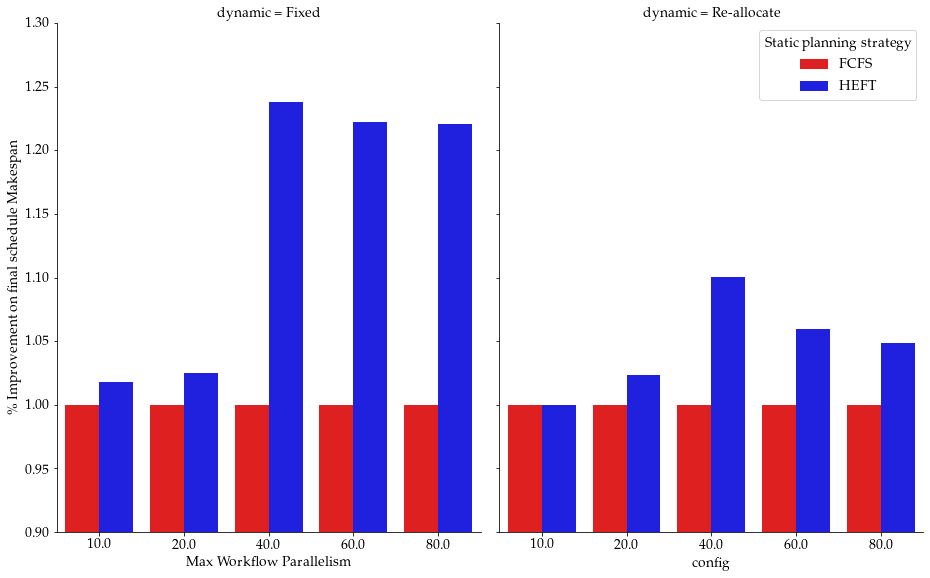

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({
    "text.usetex": True,
    "font.family": ["serif"],
    "font.serif": ["Palatino"],
    'font.size': 14
})

# fig, ax = plt.subplots(figsize=(8,4))
plot = sns.catplot(data=total_df,x='config', y='increase', hue='planning',
                   col='dynamic',kind="bar",legend=False,palette=["red", "blue"],height=8, aspect=.8)
ax = plot.axes[0][1]
h, l = ax.get_legend_handles_labels()
ax.legend(h,['FCFS','HEFT'], title='Static planning strategy',loc='upper right')
ax = plot.axes[0][0]
ax.set_ylabel('\% Improvement on final schedule Makespan')
ax.set_xlabel('Max Workflow Parallelism')
ax.set(ylim=(0.9,1.3))
# fig.savefig('ratio_comparison.png', format="png")


In [ ]:
dfnew = global_sim_new.groupby(['planning','delay', 'config']).size().astype(float).reset_index(name='time').sort_values(by=['planning'])
df_tasksnew = global_sim_new.groupby(['planning','delay', 'config'])['running_tasks'].mean().astype(float).reset_index(name='mean_tasks').sort_values(by=['planning'])
dfnew['config'] = dfnew['config'].str.replace('2021_isc-hpc/config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
df_tasksnew['config'] =df_tasksnew['config'].str.replace('2021_isc-hpc/config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)

df_tasksnew['dynamic']= ['Fixed' for x in range(10)]
plotdata_new= pd.merge(dfnew, df_tasksnew, on=['planning', 'config'])


df = global_sim.groupby(['planning','delay', 'config']).size().astype(float).reset_index(name='time').sort_values(by=['planning'])
df_tasks = global_sim.groupby(['planning','delay', 'config'])['running_tasks'].mean().astype(float).reset_index(name='mean_tasks').sort_values(by=['planning'])
df['config'] = df['config'].str.replace('visualisation_playground/sim_config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
df_tasks['config'] =df_tasks['config'].str.replace('visualisation_playground/sim_config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
df_tasks['dynamic'] = ['Re-allocated' for x in range(10)]
plotdata = pd.merge(df, df_tasks, on=['planning', 'config'])
frames = [plotdata_new,plotdata]
totalplotdata = pd.concat(frames, ignore_index=True)


In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# plotdata = pd.merge(df, df_tasks, on=['planning', 'config'])
sns.lineplot(data=totalplotdata,x='time', y='mean_tasks',hue='planning',axes=ax,linewidth = 2,
            markers=['o','o'],style='dynamic')
ax.set_ylabel('Average No. Tasks (Throughput)')
ax.set_xlabel('Simulated schedule runtime (mins)')
# ax.legend(title='Static planning strategy',labels=['FCFS','HEFT'],loc='center right')
plt.show()
# fig.savefig('tasks_throughput.svg', format="svg")
plt.show()

By doing multiw-workflow, we are optimising all workflows, not just single workflows
    * single workflows may take longer, overall plan takes less time 
    
Main goal for the thesis is science throughput 